# Isolation Forest for Anomaly Detection (Model-Based + Multivariate)

This notebook demonstrates how to combine a simple regression model (to remove predictable variation)
with an **Isolation Forest** anomaly detector applied to residuals and other process features.

**Workflow**
1. Simulate process data (or load your real dataset).
2. Fit a regression model to explain normal dependence (e.g., temperature ~ cane_rate).
3. Compute residuals (observed − predicted).
4. Build feature set for the Isolation Forest (residuals ± other variables).
5. Fit `IsolationForest`, detect anomalies, and visualize results.

In [1]:
# Step 0: Imports and plotting settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# reproducibility
RANDOM_STATE = 42

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

## Step 1 — Simulate data (or replace with your real data)

We simulate:
- `cane_rate` (context variable)
- `temp_jugo` (process variable dependent on `cane_rate`)

If you use real data, load it (CSV, DB) and ensure columns: `time`, `cane_rate`, `temp_jugo`.

In [2]:
# Step 1: Simulate (replace this block with real data load if needed)
np.random.seed(RANDOM_STATE)
n = 400
time = np.arange(n)

# Simulate cane processing rate (ton/h) with slow sinusoidal pattern + noise
cane_rate = 300 + 50 * np.sin(time / 40) + np.random.normal(0, 4, n)

# Simulate temperature (°C) with small linear dependence on cane_rate + noise
temp_jugo = 90 + 0.05 * cane_rate + np.random.normal(0, 1.0, n)

df = pd.DataFrame({"time": time, "cane_rate": cane_rate, "temp_jugo": temp_jugo})
df.head()

,time,cane_rate,temp_jugo
0,0,301.986857,103.504915
1,1,300.696813,104.435466
2,2,305.089713,105.259729
3,3,309.838605,105.538911
4,4,304.055057,104.752687


## Step 2 — Fit a regression model and compute residuals

We remove predictable variation by modeling `temp_jugo` as a function of `cane_rate`.
We will then detect anomalies in the residuals and in the joint space (residual + features).

In [3]:
# Step 2: Regression to capture expected temperature
model = LinearRegression()
model.fit(df[["cane_rate"]], df["temp_jugo"])

df["temp_pred"] = model.predict(df[["cane_rate"]])
df["residual"] = df["temp_jugo"] - df["temp_pred"]

print(f"Model: temp_jugo = {model.intercept_:.4f} + {model.coef_[0]:.6f} * cane_rate")
print("Summary residuals:", df["residual"].describe().to_string())

Model: temp_jugo = 90.5606 + 0.048064 * cane_rate
Summary residuals: count    4.000000e+02
mean    -8.135714e-15
std      1.004670e+00
min     -2.693124e+00
25%     -6.658518e-01
50%      1.366343e-02
75%      6.672571e-01
max      3.189834e+00


## Step 3 — Prepare features for IsolationForest

Options for features:
- **Univariate:** only `residual` (simple).
- **Multivariate:** `residual`, `cane_rate`, `temp_jugo` (better captures joint anomalies).
- We standardize features before fitting the Isolation Forest.

In [5]:
# Step 3: Feature engineering for IsolationForest
# Here we use residual + original variables (you can change this)
features = df[["residual", "cane_rate", "temp_jugo"]].copy()

# Optionally add lagged residuals or moving averages to capture temporal structure:
# features["resid_lag1"] = df["residual"].shift(1).fillna(0)
# features["resid_ma5"] = df["residual"].rolling(window=5, min_periods=1).mean()

# Standardize (important for models that use distances)
scaler = StandardScaler()
X = scaler.fit_transform(features)

## Step 4 — Fit the Isolation Forest

Key parameters:
- `n_estimators`: number of trees (e.g., 100).
- `max_samples`: number of samples to draw to train each tree (or "auto").
- `contamination`: expected proportion of anomalies (used to set threshold).

We will:
1. Fit the model.
2. Compute `score_samples` (higher = more normal in sklearn's transform, but note: decision_function direction).
3. Use `.predict()` (returns 1 for normal, -1 for anomaly).

In [9]:
# Step 4: Fit IsolationForest
iso = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=0.03,   # tune this: 0.01 - 0.05 typical starting points
    random_state=RANDOM_STATE,

)

# sklearn versions differ; if behaviour param not accepted ignore
try:
    iso.fit(X)
except TypeError:
    # fallback without behaviour argument
    iso = IsolationForest(n_estimators=200, max_samples="auto",
                          contamination=0.03, random_state=RANDOM_STATE)
    iso.fit(X)

# Predictions: 1 (normal), -1 (anomaly)
df["if_label"] = iso.predict(X)
# anomaly boolean
df["if_anomaly"] = df["if_label"] == -1

# Anomaly score: lower -> more anomalous; sklearn decision_function returns shifted scores (higher = more normal)
df["if_score"] = iso.decision_function(X)        # relative score, higher = more normal
df["if_score_raw"] = iso.score_samples(X)        # negative = more likely anomaly (depending on version)

print("Anomalies detected:", df["if_anomaly"].sum(), "out of", len(df))
df[["time","residual","cane_rate","temp_jugo","if_anomaly"]].head(10)

Anomalies detected: 12 out of 400


,time,residual,cane_rate,temp_jugo,if_anomaly
0,0,-1.570282,301.986857,103.504915,False
1,1,-0.577727,300.696813,104.435466,False
2,2,0.035398,305.089713,105.259729,False
3,3,0.086331,309.838605,105.538911,False
4,4,-0.421915,304.055057,104.752687,False
5,5,0.653406,305.297189,105.887709,False
6,6,-1.020621,313.788758,104.621817,False
7,7,-0.099279,311.775146,105.446378,False
8,8,0.156193,308.055569,105.523074,False
9,9,0.560541,313.325558,106.180717,False


## Step 5 — Visualize results

We produce three visuals:
1. Actual vs Predicted Temperature (anomalies highlighted)
2. Residuals over time with anomalies highlighted
3. Feature scatter (cane_rate vs temp_jugo) colored by anomaly

These help interpret whether anomalies are due to extreme residuals, unusual operating points, or joint behavior.

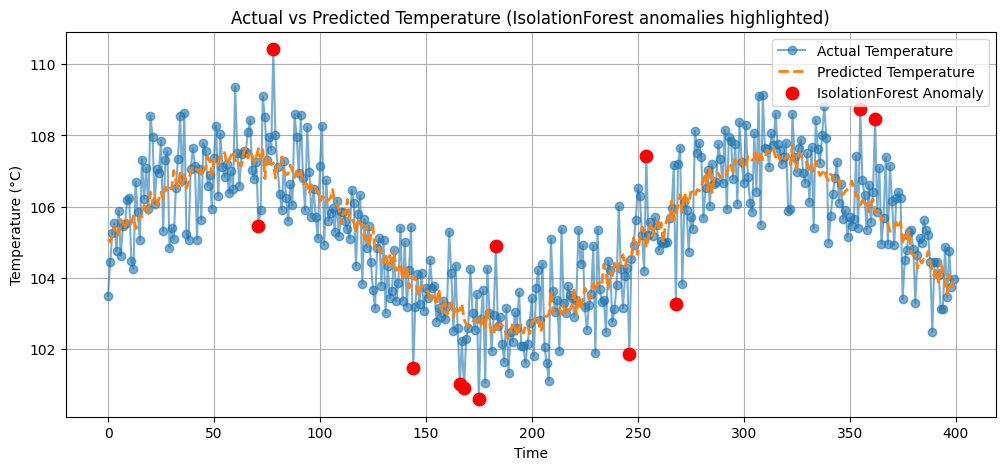

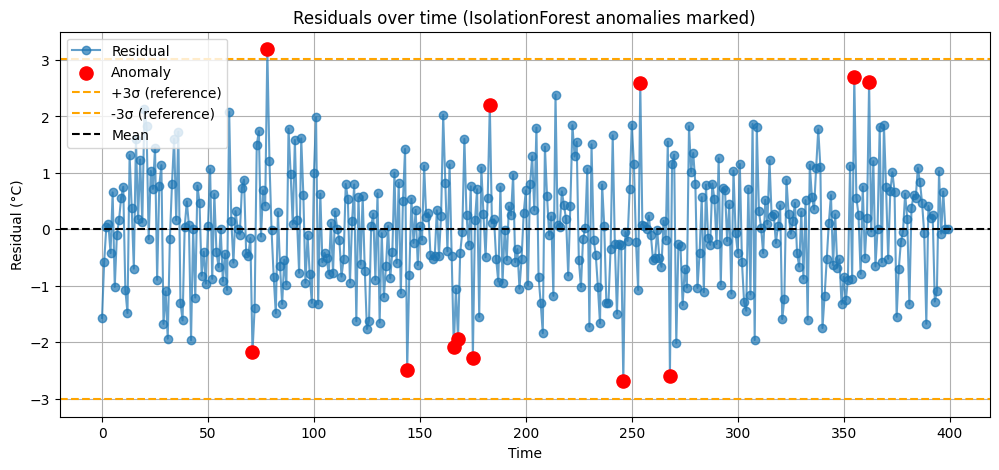

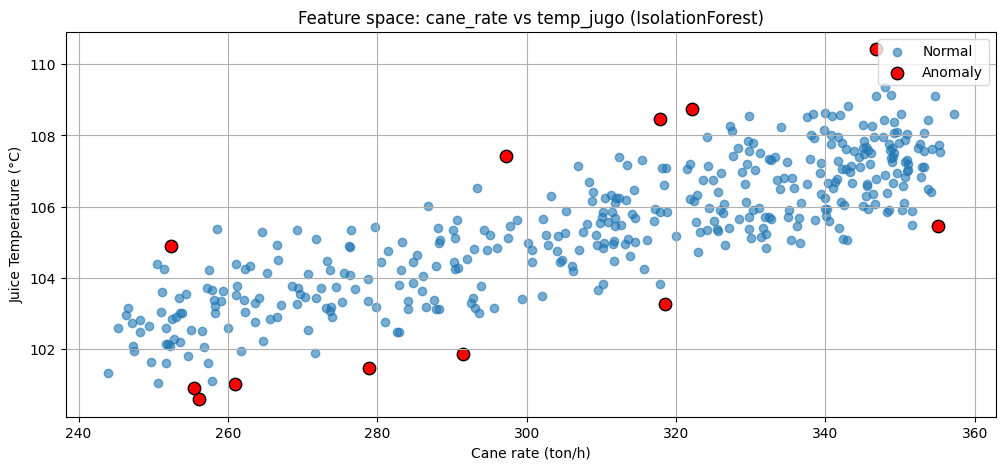

In [10]:
# Step 5: Visualizations

# 1) Actual vs Predicted (anomalies in red)
plt.figure()
plt.plot(df["time"], df["temp_jugo"], label="Actual Temperature", marker='o', linestyle='-', alpha=0.6)
plt.plot(df["time"], df["temp_pred"], label="Predicted Temperature", linestyle='--', linewidth=2)
plt.scatter(df.loc[df["if_anomaly"], "time"], df.loc[df["if_anomaly"], "temp_jugo"],
            color='red', s=80, label="IsolationForest Anomaly", zorder=5)
plt.title("Actual vs Predicted Temperature (IsolationForest anomalies highlighted)")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# 2) Residuals with anomalies
plt.figure()
plt.plot(df["time"], df["residual"], marker='o', linestyle='-', alpha=0.7, label="Residual")
plt.scatter(df.loc[df["if_anomaly"], "time"], df.loc[df["if_anomaly"], "residual"],
            color='red', s=90, label="Anomaly", zorder=5)
# Also show ±3σ for reference (optional)
mean_res = df["residual"].mean()
std_res = df["residual"].std(ddof=0)
plt.axhline(mean_res + 3*std_res, color='orange', linestyle='--', label='+3σ (reference)')
plt.axhline(mean_res - 3*std_res, color='orange', linestyle='--', label='-3σ (reference)')
plt.axhline(mean_res, color='k', linestyle='--', label='Mean')
plt.title("Residuals over time (IsolationForest anomalies marked)")
plt.xlabel("Time")
plt.ylabel("Residual (°C)")
plt.legend()
plt.show()

# 3) Feature scatter: cane_rate vs temp_jugo
plt.figure()
normal = df[~df["if_anomaly"]]
anom = df[df["if_anomaly"]]
plt.scatter(normal["cane_rate"], normal["temp_jugo"], alpha=0.6, label="Normal")
plt.scatter(anom["cane_rate"], anom["temp_jugo"], color='red', s=80, label="Anomaly", edgecolors='k')
plt.xlabel("Cane rate (ton/h)")
plt.ylabel("Juice Temperature (°C)")
plt.title("Feature space: cane_rate vs temp_jugo (IsolationForest)")
plt.legend()
plt.show()

## Step 6 — Interpret results and tune

- **`contamination`** controls how many points are labeled anomalies. Start small (0.01–0.05) if you expect few anomalies.
- **`n_estimators`** and **`max_samples`** affect stability and runtime (200 trees is a solid default).
- Use the **decision_function / score_samples** to rank anomalies: points with lowest `decision_function` are the most anomalous.
- If you want temporal consistency, consider:
  - Adding lag features (e.g., `residual_lag1`) or rolling stats (MA, STD).
  - Smoothing predictions or enforcing minimum duration for an alarm (debounce).

In [11]:
# Step 7: Rank anomalies by anomaly score and inspect
# Lower decision_function => more anomalous (in scikit-learn decision_function, higher = more normal)
df_sorted = df.sort_values(by="if_score")  # check direction in your sklearn version
top_anomalies = df_sorted.head(20)
print("Top anomalies (by decision score):")
display(top_anomalies[["time","residual","cane_rate","temp_jugo","if_score","if_anomaly"]].head(20))

Top anomalies (by decision score):


,time,residual,cane_rate,temp_jugo,if_score,if_anomaly
78,78,3.189834,346.815029,110.419632,-0.091937,True
175,175,-2.275794,256.127623,100.595246,-0.052100,True
246,246,-2.693124,291.460623,101.876145,-0.031127,True
144,144,-2.492179,278.913509,101.474031,-0.027482,True
268,268,-2.594881,318.482318,103.273146,-0.016775,True
355,355,2.695505,322.114779,108.738121,-0.015082,True
166,166,-2.093369,260.989056,101.011328,-0.012059,True
254,254,2.588354,297.260770,107.436398,-0.005701,True
168,168,-1.936783,255.439659,100.901191,-0.001318,True
362,362,2.614984,317.868255,108.453497,-0.000933,True


## Notes & Production Considerations

- **Realtime inference**: train periodically offline and load model for inference (IsolationForest doesn't support partial_fit).
- **Online retraining schedule**: retrain nightly or when process mode changes.
- **Explainability**: IsolationForest is less interpretable than residual thresholds; use the scatter / residual plot to provide context to operators.
- **Hybrid approach**: combine residual SPC (interpretable) with IsolationForest (multivariate) — raise alerts only when both agree or when IF score is extreme.
- **Export**: save model with `joblib.dump()` and a scaler to apply the same scaling in production.

## Quick tuning tips (short)
- If it marks too many anomalies: reduce contamination.
- If it misses obvious alarms: increase contamination or add more features (lags, rolling stats).
- Add domain heuristics: ignore anomalies that occur during known transient windows (start-up/shutdown) or when cane_rate is outside operating envelope.